# Importing Libraries

In [ ]:
import numpy as np
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
from keras.datasets import cifar100
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras.utils import to_categorical
from skimage.feature import hog
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
# from google.colab import drive
# drive.mount('/content/gdrive')
# from google.colab import files
from skimage import color

# Model Constants

In [ ]:
# parameters for data
n_classes = 100
k=6

# Parameters for HOG
pixels_per_cell=(4,4)
cells_per_block=(8,8)

# Loading Cifar100 data

In [ ]:
(X, y), (X_test, y_test) = cifar100.load_data()

print("The shape of X_train : ", X.shape)
print("The shape of y_train : ", y.shape)
print("The shape of X_test : ", X_test.shape)
print("The shape of y_test : ", y_test.shape)

# Cifar 100 labels
fine_label_list =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed',
                    'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 
                    'bridge', 'bus', 'butterfly','camel', 'can', 'castle',
                    'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
                    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
                    'dinosaur', 'dolphin', 'elephant', 'flatensorflowish',
                    'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo',
                    'computer_keyboard','lamp', 'lawn_mower', 'leopard', 'lion',
                    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle',
                    'mountain', 'mouse', 'mushroom','oak_tree', 'orange', 
                    'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck',
                    'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
                    'possum','rabbit', 'raccoon', 'ray', 'road', 'rocket',
                    'rose','sea', 'seal', 'shark', 'shrew', 'skunk', 
                    'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
                    'streetcar', 'sunflower', 'sweet_pepper','table', 'tank',
                    'telephone', 'television', 'tiger', 'tractor', 'train',
                    'trout', 'tulip', 'turtle','wardrobe', 'whale', 
                    'willow_tree', 'wolf', 'woman', 'worm']          

The shape of X_train :  (50000, 32, 32, 3)
The shape of y_train :  (50000, 1)
The shape of X_test :  (10000, 32, 32, 3)
The shape of y_test :  (10000, 1)


# Preprocessing Data

In [ ]:
def unison_shuffled_copies(a, b):
  randomize = np.arange(len(a))
  np.random.shuffle(randomize)
  x = a[randomize]
  y = b[randomize]
  return x, y

# Shuffling dataset
X, y = unison_shuffled_copies(X, y)

y = y.reshape(-1)
y_test = y_test.reshape(-1)
print("training labels shape : ",y.shape)
print("testing labels shape : ",y_test.shape)

training labels shape :  (50000,)
testing labels shape :  (5000,)


# Visualizing Some Samples

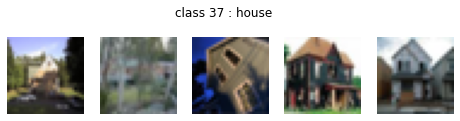

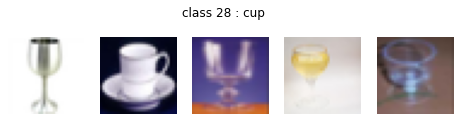

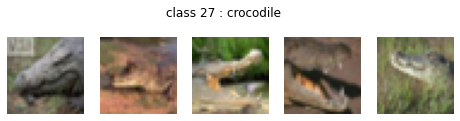

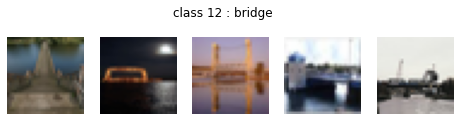

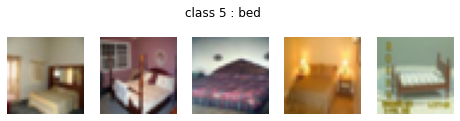

In [ ]:
num_classes= 5 # Number of classes visualized
num_samples= 5 # Number of samples from each class

class_plotted = np.random.choice(range(n_classes),num_classes, replace = False)

for i in range(len(class_plotted)):
    image_samples = X[y.reshape(-1) == class_plotted[i]][:num_samples]
    fig, ax = plt.subplots(nrows = 1, ncols = num_samples, figsize=(8,2) )
    fig.suptitle("class %d : %s" % (class_plotted[i], 
                                    fine_label_list[class_plotted[i]]) )
    for j in range(num_samples):
        ax[j].imshow(image_samples[j])
        ax[j].axis('off') 

plt.show()

# Visualizing HOG

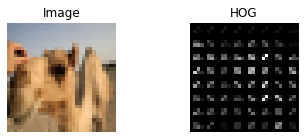

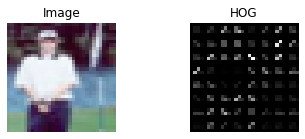

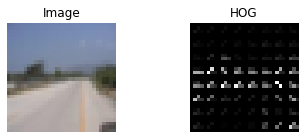

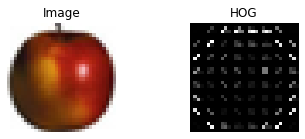

In [ ]:
for i in range(4):
  image = X[i]
  fd, hog_image = hog(image, pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block, visualize=True,
                      multichannel=True)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))

  ax1.axis('off')
  ax1.imshow(image, cmap=plt.cm.gray)
  ax1.set_title("Image")

  ax2.axis('off')
  ax2.imshow(hog_image, cmap=plt.cm.gray)
  ax2.set_title('HOG')
  plt.show()

# Data subsampling

In [ ]:
# Memory error prevention by subsampling data
num_training = 50000
mask = list(range(num_training))
X = X[mask]
y = y[mask]

num_test = 5000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]
print("Sampled training data shape : ",X.shape)
print("Sampled testing data shape : ",X_test.shape)

Sampled training data shape :  (50000, 32, 32, 3)
Sampled testing data shape :  (5000, 32, 32, 3)


# Image Preprocessing

In [ ]:
train_HOG = []
test_HOG = []

# X = [ color.rgb2gray(i) for i in X]
# X_test = [ color.rgb2gray(i) for i in X_test]

for i in range(len(X)):
  fd = hog( X[i], pixels_per_cell= pixels_per_cell, 
           cells_per_block= cells_per_block, multichannel=True)
  train_HOG.append(fd)

for i in range(len(X_test)):
  fd = hog( X_test[i], pixels_per_cell= pixels_per_cell, 
           cells_per_block= cells_per_block, multichannel=True)
  test_HOG.append(fd)

train_HOG = np.array(train_HOG)
test_HOG = np.array(test_HOG)

print("Train HOG shape : ",train_HOG.shape)
print("Test HOG shape : ",test_HOG.shape)

Train HOG shape :  (50000, 576)
Test HOG shape :  (5000, 576)


# KNN

In [ ]:
class KNearestNeighbor(object):
    def __init__(self):
        pass
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists, k=k)


    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train)) 
        dists = np.sqrt(np.sum(np.square(self.X_train), axis=1) +
                        np.sum(np.square(X), axis=1)[:, np.newaxis] - 
                        2 * np.dot(X, self.X_train.T))
        pass
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            sorted_dist = np.argsort(dists[i])
            closest_y = list(self.y_train[sorted_dist[0:k]])
            pass
            y_pred[i]= (np.argmax(np.bincount(closest_y)))
            pass
        return y_pred



# Training Model

In [ ]:
model = KNearestNeighbor()
model.train(train_HOG , y)

# Testing Model

In [ ]:
dists = model.compute_distances(test_HOG)
y_pred = model.predict_labels(dists, k=k)


test_accuracy = accuracy_score(y_test, y_pred=y_pred)*100
print(classification_report(y_test, y_pred))
print("Accuracy: "+str(test_accuracy)+ " %")
print('\n')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


              precision    recall  f1-score   support

           0       0.27      0.47      0.34        55
           1       0.20      0.43      0.27        49
           2       0.08      0.10      0.09        49
           3       0.06      0.15      0.08        55
           4       0.04      0.19      0.07        47
           5       0.25      0.35      0.29        52
           6       0.08      0.19      0.11        54
           7       0.07      0.25      0.11        55
           8       0.25      0.47      0.32        47
           9       0.34      0.63      0.44        51
          10       0.20      0.29      0.24        58
          11       0.10      0.07      0.08        59
          12       0.19      0.30      0.24        53
          13       0.15      0.22      0.18        55
          14       0.19      0.32      0.24        44
          15       0.15      0.15      0.15        46
          16       0.35      0.52      0.42        50
          17       0.13    

# Test Metrics

In [ ]:
conf_matrix = confusion_matrix(y_true= y_test, y_pred= y_pred)
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

ids = ['TP rate', 'TN rate',  'Precision',  'N prediction value',
       'FP rate', 'FN rate' ,'FD rate', 'Acc']


df = pd.DataFrame( { 'TP': TP.round(3)
                   , 'TN': TN.round(3)
                   , 'FN': FN.round(3)
                   , 'FP': FP.round(3)
                   , ids[7]: ACC.round(3)
                   , ids[0]: TPR.round(3)
                   , ids[1]: TNR.round(3)
                   , ids[2]: PPV.round(3)
                   , ids[4]: FDR.round(3)
                   , ids[5]: FNR.round(3)
                   , ids[6]: FDR.round(3)
                   , ids[3]: NPV.round(3) }
                  , index = fine_label_list  
                  )
df

,TP,TN,FN,FP,Acc,TP rate,TN rate,Precision,FP rate,FN rate,FD rate,N prediction value
apple,26,4875,29,70,0.980,0.473,0.986,0.271,0.729,0.527,0.729,0.994
aquarium_fish,21,4868,28,83,0.978,0.429,0.983,0.202,0.798,0.571,0.798,0.994
baby,5,4896,44,55,0.980,0.102,0.989,0.083,0.917,0.898,0.917,0.991
bear,8,4816,47,129,0.965,0.145,0.974,0.058,0.942,0.855,0.942,0.990
beaver,9,4756,38,197,0.953,0.191,0.960,0.044,0.956,0.809,0.956,0.992
...,...,...,...,...,...,...,...,...,...,...,...,...
whale,5,4936,43,16,0.988,0.104,0.997,0.238,0.762,0.896,0.762,0.991
willow_tree,4,4905,49,42,0.982,0.075,0.992,0.087,0.913,0.925,0.913,0.990
wolf,6,4937,42,15,0.989,0.125,0.997,0.286,0.714,0.875,0.714,0.992
woman,1,4944,53,2,0.989,0.019,1.000,0.333,0.667,0.981,0.667,0.989


# Visualizing Tests

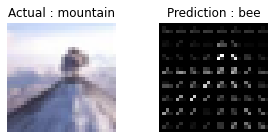

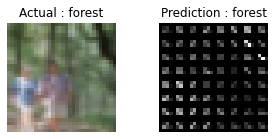

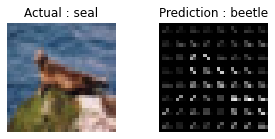

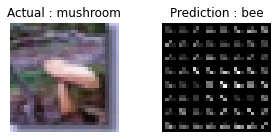

In [ ]:
n_tests = 4
start = 0
image = X_test[start: start + n_tests]
test = test_HOG[start: start + n_tests]
labels = y_test[start: start + n_tests]

pred = model.predict(test, k=k)


for i in range(len(labels)):
  
  fd, hog_image = hog(image[i],pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block, visualize=True,
                      multichannel=True)

  fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(5, 2))

  ax1.axis('off')
  ax1.imshow(image[i] , cmap=plt.cm.gray)
  ax1.set_title("Actual : " + str(fine_label_list[labels[i]]) )

  ax2.axis('off')
  ax2.imshow(hog_image, cmap=plt.cm.gray)
  ax2.set_title('Prediction : '+ str( fine_label_list[int(pred[i] )] ))

plt.show()

# Graphing Test Accuracy

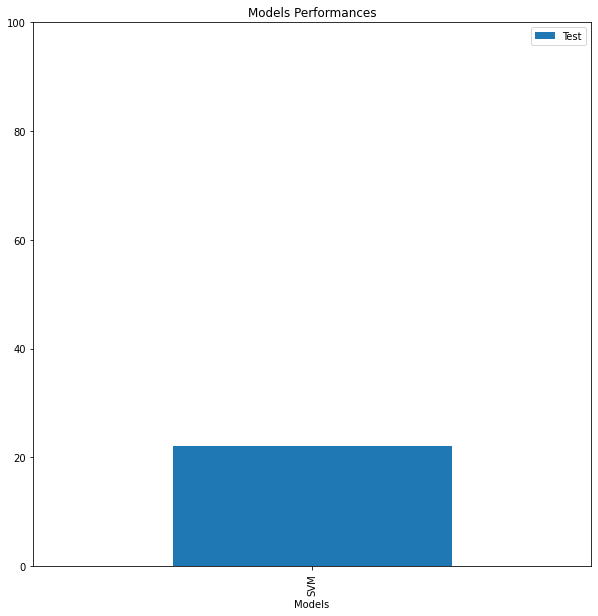

In [ ]:
df = pd.DataFrame([['SVM' , test_accuracy]],
                  columns=['Models', 'Test'])
df.plot(x='Models',
        kind='bar',
        stacked=False,
        figsize=(10,10),
        ylim=(0,100),
        title='Models Performances')